<a href="https://colab.research.google.com/github/tiskutis/Brolis/blob/main/Chemometrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [152]:
import pandas as pd
from pandas import Series
from google.colab import drive
from os.path import join
import re

In [117]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
ref_spectra = pd.read_csv('/content/drive/MyDrive/Brolis/Task/Data_prepared_syntetic/Data_prepared_syntetic/Reference_spectra.csv')

In [98]:
ref_spectra.head()

,wavelength,glucose_absorptivity,water_absorptivity
0,2000,0.02,0.021852
1,2001,0.02,0.021761
2,2002,0.02,0.021671
3,2003,0.02,0.021580
4,2004,0.02,0.021489


In [125]:
path = '/content/drive/MyDrive/Brolis/Task/Data_prepared_syntetic/Data_prepared_syntetic'
filenames = [f for f in listdir(path) if f.endswith('.h5')]

In [126]:
files = []

for filename in filenames:
  file_info = {}
  with h5py.File(join(path, filename), "r") as f:
    a_group_key = list(f.keys())[0]
    group = f[a_group_key]

    file_info['absorbance'] = group['block0_values'][()]
    file_info['wavelength'] = group['block1_values'][()]
    file_info['concentration'] = abs(float(re.findall(r"[-+]?\d*\.\d+|\d+", filename)[0]))
    files.append(file_info)

In [133]:
for file in files:
  print(min(file['wavelength']), max(file['wavelength']))

[2000] [2400]
[2000] [2400]
[2000] [2400]
[2000] [2400]
[2000] [2400]
[2000] [2400]
[2000] [2400]
[2000] [2400]
[2000] [2400]
[2000] [2400]


In [180]:
#All measurements are in range of 2000-2400 nm so I take wavelenghts only from
#the first measurement. 

data = {'Wavelength': files[0]['wavelength'].flatten()}

for file in files:
  concentration = file['concentration']
  key = f'Absorbance c={concentration}'
  data[key] = file['absorbance'].flatten()

In [181]:
df = pd.DataFrame(data)

In [182]:
df

,Wavelength,Absorbance c=0.03,Absorbance c=0.04,Absorbance c=0.07,Absorbance c=0.05,Absorbance c=0.06,Absorbance c=0.12,Absorbance c=0.1,Absorbance c=0.08,Absorbance c=0.09,Absorbance c=0.11
0,2000,0.001091,0.001085,0.001084,0.001094,0.001094,0.001080,0.001087,0.001081,0.001083,0.001079
1,2001,0.001090,0.001078,0.001078,0.001087,0.001088,0.001081,0.001084,0.001084,0.001087,0.001080
2,2002,0.001077,0.001083,0.001075,0.001071,0.001075,0.001076,0.001072,0.001090,0.001068,0.001071
3,2003,0.001082,0.001074,0.001072,0.001080,0.001078,0.001073,0.001074,0.001075,0.001080,0.001075
4,2004,0.001072,0.001075,0.001070,0.001067,0.001078,0.001068,0.001077,0.001067,0.001065,0.001065
...,...,...,...,...,...,...,...,...,...,...,...
396,2396,0.001079,0.001067,0.001073,0.001069,0.001067,0.001054,0.001069,0.001065,0.001068,0.001067
397,2397,0.001078,0.001074,0.001078,0.001077,0.001082,0.001075,0.001069,0.001070,0.001067,0.001069
398,2398,0.001084,0.001084,0.001073,0.001078,0.001079,0.001068,0.001076,0.001070,0.001074,0.001067
399,2399,0.001090,0.001090,0.001078,0.001083,0.001084,0.001076,0.001080,0.001079,0.001077,0.001079


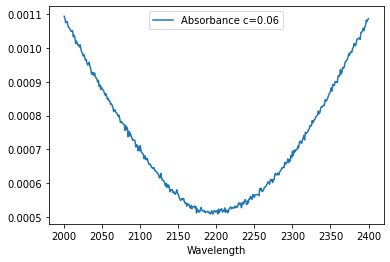

In [186]:
df.plot(x='Wavelength', y='Absorbance c=0.06')

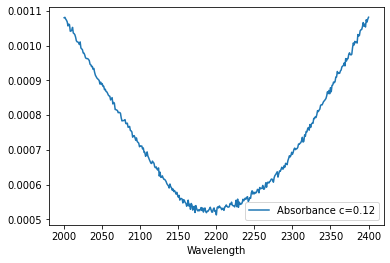

In [185]:
df.plot(x='Wavelength', y='Absorbance c=0.12')

In [ ]:
# data = group['axis0'][()] # [b'wavelength' b'absorbance']
    # data = group['axis1'][()] # index 0 - 401
    # data = group['block0_items'][()] # [b'absorbance']
    # data = group['block1_items'][()] # [b'wavelength']
    # data = group['block0_values'][()] # absorbande data i need
    # data = group['block1_values'][()] # wavelength data i need